# Setup

In [ ]:
!pip install gensim
!pip install seaborn
!pip install nltk
!pip install tensorflow

In [ ]:
import pandas as pd
import numpy as np
import sklearn

import gensim
import nltk

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# constants and global variables
DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/MLHC/Project2/Dataset/{}'
MODEL_PATH = '/content/drive/MyDrive/Colab Notebooks/MLHC/Project2/Models/{}'

is_preprocess_enabled =  False
is_w2v_train_enabled =  False
is_train_enabled = False

# Utils

In [ ]:
def save_data_to_file(file_name, data):
  with open(DATA_PATH.format(file_name), 'w') as f:
      for item in data:
          f.write("{}\n".format(item))

import json 
def read_data(file_name):
  return pd.read_csv(DATA_PATH.format(file_name), header=None).values.tolist()

# Preprocess of Data

In [ ]:
# clean the dataset, stop word removal, tokenizer etc..
if is_preprocess_enabled:

  # read the dataset
  train = open(DATA_PATH.format("train.txt"), "r").readlines()
  test = open(DATA_PATH.format("test.txt"), "r").readlines()
  dev = open(DATA_PATH.format("dev.txt"), "r").readlines()

  # tmp = (list(filter(lambda sentence: len(sentence) < 2, test)))
  # print(tmp)
  # print(len(tmp))
  
  # Removing ID and empty lines
  train = list(filter(lambda x: not x.startswith(('###', '\n')), train))
  test = list(filter(lambda x: not x.startswith(('###', '\n')), test))
  dev = list(filter(lambda x: not x.startswith(('###', '\n')), dev))

  # Building list of lists (and separating first word)
  train = list(map(lambda x: x.split('\t', 1), train))
  test = list(map(lambda x: x.split('\t', 1), test))
  dev = list(map(lambda x: x.split('\t', 1), dev))

  # Lowercasing sentence
  train = list(map(lambda x:[x[0], x[1].lower()], train))
  test = list(map(lambda x:[x[0], x[1].lower()], test))
  dev = list(map(lambda x:[x[0], x[1].lower()], dev))

  # tmp = list(map(lambda x:x[1], test))
  # tmp = (list(filter(lambda sentence: len(sentence) < 2, tmp)))
  # print(tmp)
  # print(len(tmp))

  from nltk.tokenize import RegexpTokenizer
  # Tokenizing sentence
  tokenizer = RegexpTokenizer(r'\w+')
  train = list(map(lambda x:[x[0], tokenizer.tokenize(x[1])], train))
  test = list(map(lambda x:[x[0], tokenizer.tokenize(x[1])], test))
  dev = list(map(lambda x:[x[0], tokenizer.tokenize(x[1])], dev))

  from nltk.corpus import stopwords
  # Removing stopwords
  stopwords_set = stopwords.words('english')
  train = list(map(lambda x:[x[0], [w for w in x[1] if not w in stopwords_set]], train))
  test = list(map(lambda x:[x[0], [w for w in x[1] if not w in stopwords_set]], test))
  dev = list(map(lambda x:[x[0], [w for w in x[1] if not w in stopwords_set]], dev))

  from nltk.stem import WordNetLemmatizer
  # Lemmatizing
  lemmatizer = WordNetLemmatizer()
  train = list(map(lambda x:[x[0], [lemmatizer.lemmatize(w) for w in x[1]]], train))
  test = list(map(lambda x:[x[0], [lemmatizer.lemmatize(w) for w in x[1]]], test))
  dev = list(map(lambda x:[x[0], [lemmatizer.lemmatize(w) for w in x[1]]], dev))

  for i in range(20):
    print(test[i])

In [ ]:
if is_preprocess_enabled:
  
  # devide labels from data
  y_train = list(map(lambda x:x[0], train))
  train = list(map(lambda x:x[1], train))

  y_test = list(map(lambda x:x[0], test))
  test = list(map(lambda x:x[1], test))

  y_dev = list(map(lambda x:x[0], dev))
  dev = list(map(lambda x:x[1], dev))

  for i in range(5):
    print(test[i])
    print(y_test[i])
    
  # save the labels data to a file
  save_data_to_file("y_train.txt", y_train)
  save_data_to_file("y_test.txt", y_test)
  save_data_to_file("y_dev.txt", y_dev)

In [ ]:
# detect bigrams
from gensim.models.phrases import Phrases, Phraser
from collections import defaultdict

def bigram(words):
  phrases = Phrases(words, min_count=5)
  bigram = Phraser(phrases) 
  sentences = bigram[words]

  word_freq = defaultdict(int)
  for sent in sentences:
      for i in sent:
          word_freq[i] += 1
  print(len(word_freq))

  print(sorted(word_freq, key=word_freq.get, reverse=True)[:10])

  return sentences
  

if is_preprocess_enabled:

    bigram_train = list(bigram(train))
    bigram_test = list(bigram(test))
    bigram_dev = list(bigram(dev))

    save_data_to_file("X_train.txt", bigram_train)
    save_data_to_file("X_test.txt", bigram_test)
    save_data_to_file("X_dev.txt", bigram_dev)


# Read Data

In [ ]:
import ast

# read the processed data from the repsective files
X_train = open(DATA_PATH.format("X_train.txt"), "r").readlines()
X_train = list(map(lambda x : ast.literal_eval(x), X_train))

X_test = open(DATA_PATH.format("X_test.txt"), "r").readlines()
X_test = list(map(lambda x : ast.literal_eval(x), X_test))

X_dev = open(DATA_PATH.format("X_dev.txt"), "r").readlines()
X_dev = list(map(lambda x : ast.literal_eval(x), X_dev))

# read the labels from the repsective files
y_train = open(DATA_PATH.format("y_train.txt"), "r").readlines()
y_test = open(DATA_PATH.format("y_test.txt"), "r").readlines()
y_dev = open(DATA_PATH.format("y_dev.txt"), "r").readlines()

for i in range(0, 5):
  print(X_test[i])
  print(y_test[i])

KeyboardInterrupt: ignored

# W2V Model 

In [ ]:
from gensim.models import Word2Vec
import multiprocessing

# Count the number of cores in the computer
cores = multiprocessing.cpu_count()
print(cores)

# define the  W2V model
w2v_model = Word2Vec(min_count=10,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

In [ ]:
#  build the vocabulary table
if is_w2v_train_enabled:
  w2v_model.build_vocab(X_train)

In [ ]:
if is_w2v_train_enabled:
  # train the model
  w2v_model.train(X_train, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)
  # since we don't plan to train the model any further, we use this function to make the model more memory efficient
  # model.init_sims(replace=True)

  # save the model to a file so that it can be reused without being trained from scratch
  w2v_model.save(MODEL_PATH.format("word2vec.model"))

In [ ]:
# load the trained model
w2v_model = Word2Vec.load(MODEL_PATH.format("word2vec.model"))

# Data Visualization

In [ ]:
# check which words are most similar to
w2v_model.wv.most_similar(positive=["doctor"])

In [ ]:
# return a number representing how much these two words are similar
w2v_model.wv.similarity("doctor", 'physician')

In [ ]:
# return the word that is least similar to the others in the list
w2v_model.wv.doesnt_match(['doctor', 'disease', 'patient'])

In [ ]:
# which word is to doctor as woman is to nurse
w2v_model.wv.most_similar(positive=["woman", "doctor"], negative=["nurse"], topn=3)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# draw words on a graph. Similar words  are close together in the graph.
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=19).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

In [ ]:
# visualize the 10 most similar words to doctor and 8 random words
tsnescatterplot(w2v_model, 'doctor', ['dog', 'bird', 'table', 'watch', 'pen', 'plant', 'bottle', 'backpack'])

# Obtain sentece embeddings by averaging or concatenating word embeddings

In [ ]:
# TODO write this to a file 
# given a list of sentences, for each sentence compute its emebedding by
# computing the embedding of each word in the sentence and then divide by the
# length of the phrase
def generate_senteces_embeddings(X):
  
  sentences_embedding = []
  # for each sentence in the set
  for sentence in X:
    sentence_length = len(sentence)
    # this variable will hold the sum of each word embedding in the current phrase
    sentence_embedding = np.zeros(w2v_model.vector_size)
    # for each word in the sentence
    for word in sentence:
      # embedding of the current word
      word_embedding = np.zeros(w2v_model.vector_size)

      # compute the embedding of the current word. This is not always possible as
      # not every word is in our dictionary. If this is not possible I simply discard
      # the word and decrese the sentence length by 1. 
      try:
        word_embedding = w2v_model.wv[word]
      except KeyError:
        sentence_length = sentence_length - 1
      
      sentence_embedding = sentence_embedding + word_embedding 
    
    # in our dataset there are some (very few) length 1 sentences
    # with one single word that is not part of the model vocabulary.
    # In order to prevent a divison by 0, this if stattement is necessary.
    if sentence_length == 0:
      sentence_embedding = np.zeros(w2v_model.vector_size)
    else:
      sentence_embedding = sentence_embedding / sentence_length

    # add the sentence embedding to the list that will be returned
    sentences_embedding.append(np.array(sentence_embedding))
  

  return sentences_embedding

X_train_se = np.array(generate_senteces_embeddings(X_train))
X_test_se = np.array(generate_senteces_embeddings(X_test))
X_dev_se = np.array(generate_senteces_embeddings(X_dev))




# Create Models to perform prediction of different classes

In [ ]:
# perform one hot encoding
from tensorflow.keras.utils import to_categorical

labels = ['BACKGROUND', "OBJECTIVE", "METHODS", "RESULTS", "CONCLUSIONS"]

# map each label to an integer
mapping = {}
for x in range(len(labels)):
  mapping[labels[x]] = x

def from_label_to_integer(y):
  y = list(y)
  for x in range(len(y)):
    y[x] = int(mapping[y[x].strip("\n")])
  
  return y


y_train = np.argmax(np.array(to_categorical(from_label_to_integer(y_train))), axis=-1)
y_test = np.argmax(np.array(to_categorical(from_label_to_integer(y_test))), axis=-1)
y_dev = np.argmax(np.array(to_categorical(from_label_to_integer(y_dev))), axis=-1)

## CNN

In [ ]:
# --------------------------------------------------------
# ------------------------- CNN -------------------------
# --------------------------------------------------------
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Dense, GlobalAveragePooling1D
from tensorflow.keras import losses

# create the model
model = Sequential()
model.add(Conv1D(128, 30, activation='relu', input_shape=(300, 1)))
model.add(MaxPooling1D(2))
model.add(Dropout(0.1))
model.add(Conv1D(128, 25, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Dropout(0.1))
model.add(Conv1D(128, 10, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Dropout(0.5))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalAveragePooling1D())
# model.add(Flatten())
model.add(Dense(256, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(128, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(5, kernel_initializer='normal', activation='softmax'))

# model.summary()

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss=losses.sparse_categorical_crossentropy, metrics=['acc'])

tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)
print("Number of weights: {}".format(model.count_params()))

Number of weights: 734213


In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

file_path = MODEL_PATH.format("CNN_task2.h5")
callbacks = [
             ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max'),
             ReduceLROnPlateau(monitor="val_acc", mode="max", patience=3, verbose=2),
             EarlyStopping(monitor="val_acc", mode="max", patience=5, verbose=1)
             ]
if is_train_enabled:
  history = model.fit(X_train_se, y_train, epochs=100, verbose=1, callbacks=callbacks, validation_data=(X_dev_se, y_dev), batch_size=64)

Epoch 1/100
34561/34561 [==============================] - ETA: 0s - loss: 0.7136 - acc: 0.7279
Epoch 1: val_acc improved from -inf to 0.74803, saving model to /content/drive/MyDrive/Colab Notebooks/MLHC/Project2/Models/CNN_task2.h5
34561/34561 [==============================] - 319s 9ms/step - loss: 0.7136 - acc: 0.7279 - val_loss: 0.6657 - val_acc: 0.7480 - lr: 0.0010
Epoch 2/100
34560/34561 [============================>.] - ETA: 0s - loss: 0.6502 - acc: 0.7582
Epoch 2: val_acc improved from 0.74803 to 0.75702, saving model to /content/drive/MyDrive/Colab Notebooks/MLHC/Project2/Models/CNN_task2.h5
34561/34561 [==============================] - 311s 9ms/step - loss: 0.6502 - acc: 0.7582 - val_loss: 0.6423 - val_acc: 0.7570 - lr: 0.0010
Epoch 3/100
34561/34561 [==============================] - ETA: 0s - loss: 0.6385 - acc: 0.7631
Epoch 3: val_acc improved from 0.75702 to 0.75926, saving model to /content/drive/MyDrive/Colab Notebooks/MLHC/Project2/Models/CNN_task2.h5
34561/34561 [==

In [ ]:
# load the model from the corresposning h5 file
model.load_weights(MODEL_PATH.format("CNN_task2.h5"))

In [ ]:
from sklearn.metrics import f1_score, accuracy_score

y_pred = model.predict(X_test_se)
y_pred = np.argmax(y_pred, axis=-1)

f1 = f1_score(y_test, y_pred, average="macro")

print("Test f1 score : %s "% f1)

acc = accuracy_score(y_test, axis=-1), y_pred)

print("Test accuracy score : %s "% acc)

Test f1 score : 0.6883908645890027 
Test accuracy score : 0.778150747635032 


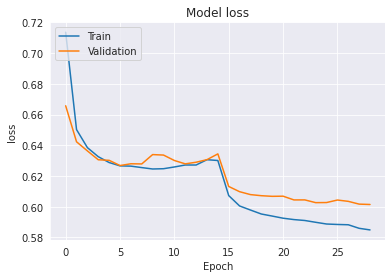

In [ ]:
if is_train_enabled:
  # Plot training & validation loss values
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

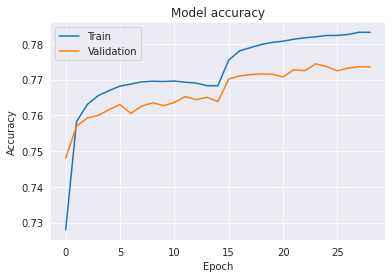

In [ ]:
if is_train_enabled:
  # Plot training & validation accuracy values
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

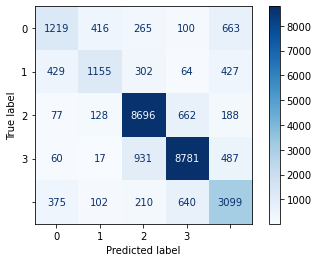

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

# Plotting confusion matrix
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3])

disp.plot(cmap=plt.cm.Blues)
plt.show()

## Feed Forward Neural Network

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

model = Sequential()
model.add(Dense(512, input_dim=300, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64,  activation='relu'))
model.add(Dense(64,  activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(5, activation='softmax'))

model.compile(
  optimizer='adam',
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy'],
)

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

file_path = MODEL_PATH.format("MLP_task2.h5")
callbacks = [
             ModelCheckpoint(file_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'),
             ReduceLROnPlateau(monitor="val_accuracy", mode="max", patience=3, verbose=2),
             EarlyStopping(monitor="val_accuracy", mode="max", patience=5, verbose=1)
             ]
if is_train_enabled:
  history = model.fit(X_train_se, y_train, epochs=100, verbose=1, callbacks=callbacks, validation_data=(X_dev_se, y_dev), batch_size=128)

Epoch 1/100
17272/17281 [============================>.] - ETA: 0s - loss: 0.5883 - accuracy: 0.7852
Epoch 1: val_accuracy improved from -inf to 0.78335, saving model to /content/drive/MyDrive/Colab Notebooks/MLHC/Project2/Models/MLP_task2_5.h5
17281/17281 [==============================] - 55s 3ms/step - loss: 0.5883 - accuracy: 0.7852 - val_loss: 0.5956 - val_accuracy: 0.7834 - lr: 0.0010
Epoch 2/100
17276/17281 [============================>.] - ETA: 0s - loss: 0.5427 - accuracy: 0.8012
Epoch 2: val_accuracy improved from 0.78335 to 0.78761, saving model to /content/drive/MyDrive/Colab Notebooks/MLHC/Project2/Models/MLP_task2_5.h5
17281/17281 [==============================] - 53s 3ms/step - loss: 0.5427 - accuracy: 0.8012 - val_loss: 0.5714 - val_accuracy: 0.7876 - lr: 0.0010
Epoch 3/100
17274/17281 [============================>.] - ETA: 0s - loss: 0.5309 - accuracy: 0.8055
Epoch 3: val_accuracy improved from 0.78761 to 0.79165, saving model to /content/drive/MyDrive/Colab Noteboo

In [ ]:
# load the model from the corresposning h5 file
model.load_weights(MODEL_PATH.format("MLP_task2.h5"))

In [ ]:
from sklearn.metrics import f1_score, accuracy_score

y_pred = np.argmax(model.predict(X_test_se), axis=-1)

f1 = f1_score(y_test, y_pred, average="macro")

print("Test f1 score : %s "% f1)

acc = accuracy_score(y_test, y_pred)

print("Test accuracy score : %s "% acc)

Test f1 score : 0.7295973671243317 
Test accuracy score : 0.8068355202929509 


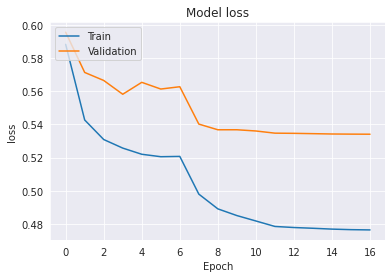

In [ ]:

if is_train_enabled:
  # Plot training & validation loss values
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

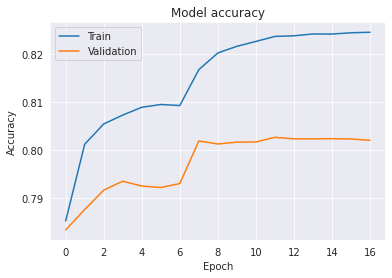

In [ ]:
if is_train_enabled:
  # Plot training & validation accuracy values
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

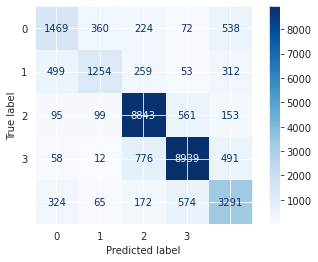

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

# Plotting confusion matrix
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3])

disp.plot(cmap=plt.cm.Blues)
plt.show()